Monte Carlo Prediction

First-visit MC prediction, for estimating $$V ≈ v_\pi$$

Initialize:

π ← policy to be evaluated

V ← an arbitrary state-value function

Returns(s) ← an empty list, for all s ∈ S

Repeat forever:

Generate an episode using π

For each state s appearing in the episode:

G ← the return that follows the first occurrence of s

Append G to Returns(s)

V (s) ← average(Returns(s))



Example 5.1: Blackjack The object of the popular casino card game of blackjack is to obtain cards
the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as
10, and an ace can count either as 1 or as 11. We consider the version in which each player competes
independently against the dealer. The game begins with two cards dealt to both dealer and player. One
of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and
a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the
game is a draw. If the player does not have a natural, then he can request additional cards, one by one
(hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then
it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins;
otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an
episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards
within a game are zero, and we do not discount (γ = 1); therefore these terminal rewards are also the
returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the
dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so
that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he
could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted
as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be
made because, obviously, the player should always hit. Thus, the player makes decisions on the basis
of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not
he holds a usable ace. This makes for a total of 200 states.

Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits. To find the state-
value function for this policy by a Monte Carlo approach, one simulates many blackjack games using
the policy and averages the returns following each state. Note that in this task the same state never
recurs within one episode, so there is no difference between first-visit and every-visit MC methods. In
this way, we obtained the estimates of the state-value function shown in Figure 5.1. The estimates for
states with a usable ace are less certain and less regular because these states are less common. In any
event, after 500,000 games the value function is very well approximated.


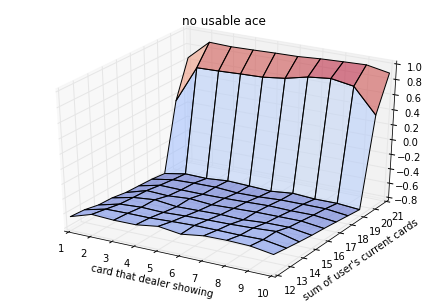

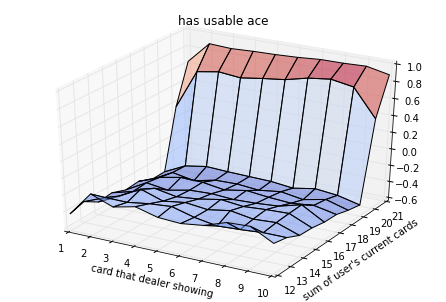

In [12]:
import random
import numpy as np
import itertools
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def getCard():
    c = random.randint(1,13)
    if c>10:
        c = 10
    return c

def getAction(curr_sum):
    a = 'hit'
    if curr_sum >= 20:
        a = 'stick'
    return a

def getDealerAction(dealer_curr_sum):
    a = 'hit'
    if dealer_curr_sum >= 17:
        a = 'stick'
    return a

#initialize
state_curr_sum_list = np.arange(12,22)
state_dealer_showing_list = np.arange(1,11)
state_usable_ace_list = [0,1]
action_list = ['hit','stick']
state_values = {}
returns = {}
for s in itertools.product(state_curr_sum_list,state_dealer_showing_list,state_usable_ace_list):
    state_values[s] = 0
    returns[s] = []

loops = 500000

for k in range(loops):
    episode = []
    c1 = getCard()
    c2 = getCard()
    dealer_c1 = getCard()
    dealer_c2 = getCard()
    #print c1,c2,dealer_c1,dealer_c2
    usable_ace = 0
    curr_sum = c1 + c2
    dealer_showing = dealer_c1    
    if c1 == 1 or c2 == 1:
        usable_ace = 1
        curr_sum = curr_sum + 10
    #print (curr_sum,dealer_showing,usable_ace)
    a = getAction(curr_sum)    
    burst = False
    if curr_sum > 11:
        episode.append((curr_sum,dealer_showing,usable_ace))
    
    user_cards = [c1,c2]
    dealer_cards = [dealer_c1,dealer_c2]
    while a == 'hit' and not burst:
        c = getCard()
        user_cards.append(c)
        curr_sum = curr_sum + c
        if curr_sum > 21 and usable_ace == 0:
            burst = True
        elif curr_sum > 21 and usable_ace == 1:
            usable_ace = 0
            curr_sum = curr_sum - 10
            a = getAction(curr_sum)
        elif curr_sum < 12:            
            if c == 1:
                curr_sum = curr_sum + 10
                usable_ace = 1
                a = getAction(curr_sum)
            else:
                a = 'hit'                    
        else:
            a = getAction(curr_sum)
        if curr_sum>11 and not burst:
            episode.append((curr_sum,dealer_showing,usable_ace))        
    r = 0
    if burst:
        r = -1
    else:
        #dealer's turn
        dealer_curr_sum = dealer_c1 + dealer_c2
        dealer_usable_ace = 0
        if dealer_c1==1 or dealer_c2==1:
            dealer_curr_sum = dealer_curr_sum + 10
            dealer_usable_ace = 1
        if dealer_curr_sum >= 17:
            if dealer_curr_sum > curr_sum:
                r = -1
            elif dealer_curr_sum == curr_sum:
                r = 0
            else:
                r = 1
        else:
            dealer_a = 'hit'
            dealer_burst = False
            while dealer_a == 'hit' and not dealer_burst:
                dealer_c = getCard()
                dealer_cards.append(dealer_c)
                dealer_curr_sum = dealer_curr_sum + dealer_c
                if dealer_curr_sum > 21 and dealer_usable_ace == 0:
                    dealer_burst = True
                elif dealer_curr_sum > 21 and dealer_usable_ace == 1:
                    dealer_usable_ace = 0
                    dealer_curr_sum = dealer_curr_sum - 10
                    dealer_a = getDealerAction(dealer_curr_sum)                
                elif dealer_curr_sum < 12:                    
                    if dealer_c == 1:
                        dealer_curr_sum = dealer_curr_sum + 10
                        dealer_usable_ace = 1
                        dealer_a = getDealerAction(dealer_curr_sum)
                    else:
                        dealer_a = 'hit'   
                else:
                    dealer_a = getDealerAction(dealer_curr_sum)                
            if dealer_burst:
                r = 1
            elif dealer_curr_sum < curr_sum:
                r = 1
            elif dealer_curr_sum == curr_sum:
                r =0
            else:
                r = -1
    #print "user:{}".format(user_cards)
    #print "user sum:{} dealer_showing:{} usable_ace: {}".format(curr_sum,dealer_showing,usable_ace)            
    #print "dealer:{}".format(dealer_cards)
    #print "dealer sum:{} dealer_usable_ace: {}".format(dealer_curr_sum,dealer_usable_ace)
    #print "reward: {}".format(r)
    for s in episode:
        returns[s].append(r)
for s in itertools.product(state_curr_sum_list,state_dealer_showing_list,state_usable_ace_list):
    state_values[s]  = np.mean(returns[s])

X,Y = np.meshgrid(state_dealer_showing_list,state_curr_sum_list)
Z = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        Z[i][j] = state_values[(Y[i][j],X[i][j],0)]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.cm.coolwarm,alpha=0.5)
plt.xlabel('card that dealer showing')
plt.ylabel("sum of user's current cards")
plt.title("no usable ace")
plt.show()

Z = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        Z[i][j] = state_values[(Y[i][j],X[i][j],1)]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap=plt.cm.coolwarm,alpha=0.5)
plt.xlabel('card that dealer showing')
plt.ylabel("sum of user's current cards")
plt.title("has usable ace")
plt.show()
            
